# Introduction
  In Reddit, there is a subreddit called WallStreetBets (r/wallstreetbets) where participants discuss stock and option trading. This subreddit went viral because it caused a significant fluctuation in the stock prices of GameStop in January 2021.
  
We obtained the dataset around that time from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts) to analysis the relationship between the post and stock price and also perform sentiment analysis.

In addtion, we obtain the dataset by ourselves with [Praw](https://github.com/praw-dev/praw) package in Python on r/wallstreetbets. The dataset included the recent post (Novembere 2023) and some hottest post in 2023.

# The required packages

In [87]:
import pandas as pd
import re
import os
import openai
from time import sleep
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import yfinance as yf
from collections import Counter
## for plot
from datetime import datetime, timedelta, timezone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.io as pio
import praw
# correlation
import scipy
import operator

[nltk_data] Downloading package stopwords to /Users/thl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Function in Use

The `get_post_freq` function returns a Dataframe that summary the post frequency of given DataFrame into the `timestamp` and `frequency` columns. The frequency shows the number of posts in [`timestamp`, `timestamp` + `interval`). 

In [2]:
def get_post_freq(timestamps, interval: timedelta, start_time: datetime = None, end_time: datetime = None) -> pd.DataFrame:
    datetime_list = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in sorted(timestamps)] # convert string to datetime
    if len(datetime_list) == 0:
        return pd.DataFrame(columns=["timestamp", "frequency"])
    if start_time == None:
        start_time = datetime_list[0]
    if end_time == None:
        end_time = datetime_list[-1] + timedelta(seconds=1)
        
    datetime_list = [elem for elem in datetime_list if elem >= start_time and elem < end_time] # choose timestamps in the range from start_time to end_time
    datetime_list = [(elem - start_time) // interval for elem in datetime_list] # assign each timestamps to each interval
    datetime_list = [start_time + interval * elem for elem in datetime_list] # restore the real timestamps of each interval
    freq_list = list(Counter(datetime_list).items()) # aggregate timestamps into each interval

    if freq_list[-1][0] < end_time - interval: # add end bound
        freq_list.append((end_time - interval, 0))
    if freq_list[0][0] > start_time: # add start bound
        freq_list.insert(0, (start_time, 0))
    
    for i in range(len(freq_list)-2, -1, -1): # add 0s into the interval between two real records
        if freq_list[i + 1][0] - freq_list[i][0] > 2 * interval:
            freq_list.insert(i + 1, (freq_list[i + 1][0] - interval, 0))
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
        elif freq_list[i + 1][0] - freq_list[i][0] == 2 * interval:
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
    
    freq_df = pd.DataFrame(freq_list, columns=["timestamp", "frequency"])
    return freq_df

In [3]:
def plot_post_freq(df, interval = 1):
    interval = timedelta(days=interval)
    freq_df = get_post_freq(df["timestamp"], interval)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=freq_df["timestamp"],
        y=freq_df["frequency"],
        xperiod=interval.total_seconds()*1000
    ))
    fig.update_layout(
        title_text=f"Post frequency",
        xaxis_title=f"timestamp (day)",
        yaxis_title="the number of post",
        # width=1000,
        # height=500,
    )
    fig.show()

# Prepare Dataset

## Dataset from Kaggle
Just download it from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts).

In [48]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")

Some basic information of dataset

title  score      id  \
19537  GameStop short Melvin Capital lost 53% in January    175  l9pgct   
43367  Still shorting GME on downticks during restric...   2236  md169q   
9120   Can and should WallStreetBets really create an...      1  l70tpa   

                                                     url  comms_num  \
19537  https://www.marketwatch.com/story/gamestop-sho...         45   
43367                https://i.redd.it/su08n0to27p61.png        329   
9120   https://www.reddit.com/r/wallstreetbets/commen...          3   

            created                                               body  \
19537  1.612166e+09                                                NaN   
43367  1.616716e+09                                                NaN   
9120   1.611879e+09  Is that even legal?\n\nI’d be willing to inves...   

                 timestamp  
19537  2021-02-01 09:50:00  
43367  2021-03-26 01:42:18  
9120   2021-01-29 02:09:29


   The number of row: 53187
   The number of column: 8
   The first timestamp: 2020-09-29 03:46:56
   The last timestamp: 2021-08-16 09:26:20



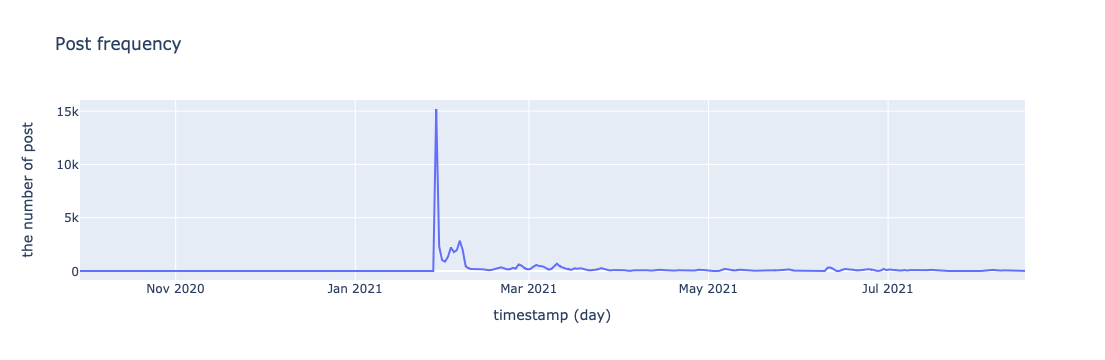

In [26]:
display(df_kaggle.sample(3))
info = f"""
   The number of row: {df_kaggle.shape[0]}
   The number of column: {df_kaggle.shape[1]}
   The first timestamp: {df_kaggle.sort_values(["created"])["timestamp"].values[0]}
   The last timestamp: {df_kaggle.sort_values(["created"])["timestamp"].values[-1]}
"""
print(info)
plot_post_freq(df_kaggle)

## Recent Dataset around November 2023

Use Praw package to obtain the data from Reddit API.

In [6]:
# The same columns as the kaggle dataset
df_2023 = pd.DataFrame(columns = ['title', 'score', 'id', 'url', 'comms_num', 'created', 'body', 'timestamp'])

In [24]:
# User's credential
reddit = praw.Reddit(
    client_id="VjQhhXD0WiNzaBsUBcOXsQ",
    client_secret="ZIwQQo6_2mJ16woXKFPiE3-ArYOxug",
    user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
)

# The target subreddit is "r/wallstreetbets"
subreddit = reddit.subreddit("wallstreetbets")

# Reddit limits it to 1000 so their servers don't die.
limit = 1000
for g in [subreddit.new(limit=limit), subreddit.top(limit=limit), subreddit.hot(limit=limit), subreddit.rising(limit=limit)]:
    for submission in g:
        data = {
            "title": submission.title,
            "score": submission.score,
            "id": submission.id,
            "url": submission.url,
            "comms_num": submission.num_comments,
            "created": submission.created_utc,
            "body": submission.selftext,
            "timestamp": datetime.fromtimestamp(submission.created_utc, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        }
        df_2023.loc[len(df_2023)] = data

In [ ]:
# Drop duplicated data
df_2023 = df_2023.drop_duplicates(["id"], ignore_index = True)

# Only included the data in year 2023
df_2023 = df_2023[df_2023["created"] >= datetime.timestamp(datetime(2023, 1, 1, tzinfo=timezone.utc))].reset_index(drop = True)
df_2023 = df_2023.sort_values(["created"], ignore_index = True)

It might take a little time to grab the data. We have already run the above code beforehand and store the dataset in `./dataset/reddit_wsb_2023.csv`. Just load it to save your time.

In [28]:
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

Some basic information of dataset

title  score       id  \
846  Sold TSLA calls at the peak this morning, +$22...    131  18bj0mo   
55                     $1.2k —> $10.7k thanks to $TSLA    519  17z23qx   
405                                         Tesla Puts   3131  18521al   

                                        url  comms_num       created  \
846     https://i.redd.it/nxz8xx4oui4c1.jpg         36  1.701802e+09   
55   https://www.reddit.com/gallery/17z23qx         69  1.700415e+09   
405     https://i.redd.it/bs4dg653yv2c1.jpg        320  1.701089e+09   

                                                  body            timestamp  
846                                                NaN  2023-12-05 18:44:22  
55   Buying dips, selling rips and shorting pullbacks.  2023-11-19 17:26:42  
405                                           Ok noted  2023-11-27 12:38:26


   The number of row: 919
   The number of column: 8
   The first timestamp: 2023-01-04 09:50:17
   The last timestamp: 2023-12-06 18:23:46



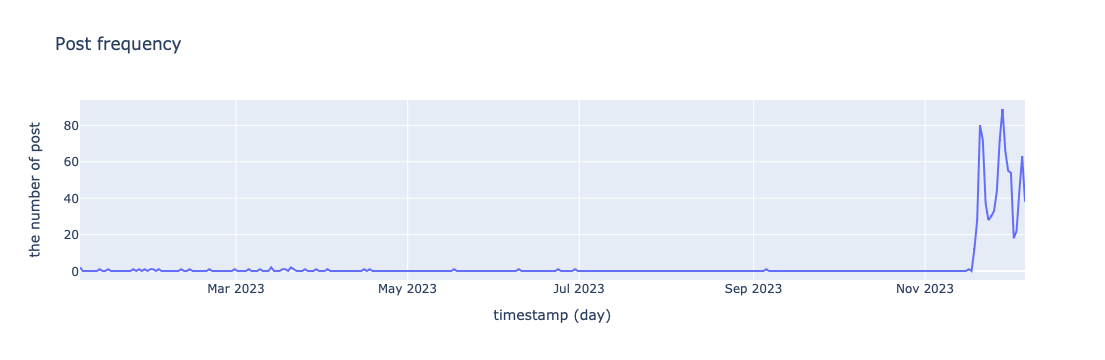

In [29]:
display(df_2023.sample(3))
info = f"""
   The number of row: {df_2023.shape[0]}
   The number of column: {df_2023.shape[1]}
   The first timestamp: {df_2023.sort_values(["created"])["timestamp"].values[0]}
   The last timestamp: {df_2023.sort_values(["created"])["timestamp"].values[-1]}
"""
print(info)
plot_post_freq(df_2023)

# Research Question 1

<b>What are the immediate effects on stock prices of companies mentioned in highly upvoted or viral posts on platforms like WallStreetBets?</b>

To solve this question, we first start with find out the ticker symbol in the context. We have two approachs:<br/>
- <b>Method1:</b> Extract the captialize words in the post.
- <b>Method2:</b> Use openai API to extract the ticker symbol in the context.
<br/>

For both methods, we have to clean up the dataset beforehand.

## Pre-processing

In [49]:
def remove_hyperlink(body):
    body = re.sub(r'https?://\S+|www\.\S+', '', body)
    # body = re.sub(r'/\S/\S+', '', body)
    return body

def remove_punctuation(body):
    punctuation = '!"#%&\()*+,-.:;<=>?@[\\]^_`{|}~'
    body = re.sub(rf'[{punctuation}\\\s]+', " ", body)
    return body

In [50]:
def data_preprocessing(df):
    df["body"].fillna(value = "", inplace = True)
    df["body"] = df["title"] + ": "+ df["body"]
    df["body"] = df["body"].apply(remove_hyperlink)
    df["body"] = df["body"].apply(remove_punctuation)

In [51]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

## Method1: Extract the capitalize words in the post

In [65]:
stopwords_set = set([i.upper() for i in stopwords.words("english")] + [i for i in stopwords.words("english")])
def remove_stopword(body):
    words = set(body.split(" "))
    words = words - stopwords_set
    return " ".join(words)

def find_potential_ticker_symbol(body):
    return set(re.findall(r'\b[A-Z]+\b', body))

In [68]:
def find_top_n_ticker_symbol(df, n = 10):
    df["ticker symbol"] = df["body"]
    df["ticker symbol"] = df["ticker symbol"].apply(remove_stopword)
    df["ticker symbol"] = df["ticker symbol"].apply(find_potential_ticker_symbol)
    # find potential ticker symbol
    potential_ticker_symbol_freq = Counter({})
    for i in df["ticker symbol"]:
        potential_ticker_symbol_freq += Counter({k:1 for k in i})

    # find top n ticker symbol
    cnt = 0
    ticker_symbol_top_n = []
    potential_ticker_symbol_sort = [i[0] for i in potential_ticker_symbol_freq.most_common(len(potential_ticker_symbol_freq))]
    for i in potential_ticker_symbol_sort:
        if cnt == n:
            break
        ticker = yf.Ticker(i)
        # _ = ticker.info
        out = ticker.history()
        if out.shape[0]:
            ticker_symbol_top_n.append(i)
            print(f"{i} is a ticker symbol")
            cnt += 1
            
    # Propagation        
    company_name = [yf.Ticker(i).info['longName'].split(" ")[0].upper() for i in ticker_symbol_top_n]
    name_ticker_map = pd.DataFrame([ticker_symbol_top_n], columns = company_name)
    for i in range(df.shape[0]):
        body_set = set(df.loc[i, "body"].upper().split(" "))
        df.at[i, "ticker symbol"] = df.loc[i, "ticker symbol"] | ( (body_set & set(ticker_symbol_top_n) ) | set(name_ticker_map.loc[0, list(body_set & set(company_name))].values))
        
    # If appear in post show "True", if not show "False"
    df.loc[:,ticker_symbol_top_n] = False
    # if appear set True
    for i in range(df.shape[0]):
        df.loc[i, list(df.loc[i, "ticker symbol"] & set(ticker_symbol_top_n))] = True

    return ticker_symbol_top_n

In [69]:
ticker_symbol_top_n_kaggle = find_top_n_ticker_symbol(df_kaggle, 10)
ticker_symbol_top_n_kaggle

GME is a ticker symbol


I: No data found, symbol may be delisted


AMC is a ticker symbol
DD is a ticker symbol


WSB: No price data found, symbol may be delisted (period=1mo)
HOLD: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)


YOLO is a ticker symbol
BB is a ticker symbol


BUY: No price data found, symbol may be delisted (period=1mo)
TLDR: No price data found, symbol may be delisted (period=1mo)


NOK is a ticker symbol
RH is a ticker symbol


SEC: No price data found, symbol may be delisted (period=1mo)
CEO: No data found, symbol may be delisted
FUCKING: No data found, symbol may be delisted
P: No price data found, symbol may be delisted (period=1mo)
DR: No price data found, symbol may be delisted (period=1mo)


MOON is a ticker symbol


TL: Period '1mo' is invalid, must be one of ['1d', '5d']
SELL: No data found, symbol may be delisted


PLTR is a ticker symbol
EDIT is a ticker symbol


['GME', 'AMC', 'DD', 'YOLO', 'BB', 'NOK', 'RH', 'MOON', 'PLTR', 'EDIT']

According to the output, we obtain the top 10 ticker symbols: 
1. GME
2. AMC
3. DD
4. YOLO
5. BB
6. NOK
7. RH
8. MOON
9. PLTR
10. EDIT

In [70]:
ticker_symbol_top_n_2023 = find_top_n_ticker_symbol(df_2023, 10)
ticker_symbol_top_n_2023 

I: No data found, symbol may be delisted
CEO: No data found, symbol may be delisted
WSB: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)
P: No price data found, symbol may be delisted (period=1mo)


AI is a ticker symbol
NVDA is a ticker symbol
MSFT is a ticker symbol


ETF: No price data found, symbol may be delisted (period=1mo)


U is a ticker symbol
SPY is a ticker symbol
DM is a ticker symbol
SAVE is a ticker symbol
E is a ticker symbol
YOLO is a ticker symbol
DD is a ticker symbol


['AI', 'NVDA', 'MSFT', 'U', 'SPY', 'DM', 'SAVE', 'E', 'YOLO', 'DD']

According to the output, we obtain the top 10 ticker symbols: 
1. AI
2. NVDA
3. MSFT
4. U
5. SPY
6. DM
7. SAVE
8. E
9. YOLO
10. DD

### sentiment analysis

In [71]:
def sentiment_anaysis(df, top_n_ticker_symbol):
    def categorize_sentiment(score):
        if score > 0:
            return 1
        elif score < 0:
            return 2
        else:
            return 0
    sia = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['body'].apply(lambda x: sia.polarity_scores(x)['compound']).apply(categorize_sentiment)
    df[top_n_ticker_symbol] = df[top_n_ticker_symbol].astype('float')
    for ticker in top_n_ticker_symbol:
        df.loc[df[ticker] == 0, ticker] = pd.NA
        df.loc[df[ticker] == 1, ticker] = df.loc[df[ticker] == 1, 'sentiment_score']

In [72]:
sentiment_anaysis(df_kaggle, ticker_symbol_top_n_kaggle)

In [73]:
sentiment_anaysis(df_2023, ticker_symbol_top_n_2023)

## Plot the stock price and the appear frequence of ticker symbol

In [74]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    df = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Open"],
            name = f"Stock open",
            marker=dict(color="#00CC96")
        )
    )
    
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Volume"],
            name = f"Stock volume",
            yaxis="y2",
            marker=dict(color="#636EFA")
        )
    )
    
    fig.add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color="#FFA15A")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color="red")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.8,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color="purple")
    ))


    # Create axis objects
    fig.update_layout(
        yaxis=dict(
            title=f"Stock Open",
            titlefont=dict(
                color="#00CC96"
            ),
            tickfont=dict(
                color="#00CC96"
            )
        ),
        yaxis2=dict(
            title=f"Stock Volume",
            titlefont=dict(
                color="#636EFA"
            ),
            tickfont=dict(
                color="#636EFA"
            ),
            anchor="free",
            overlaying="y",
            side="left",
            autoshift=True,
            shift=-50,
        ),
        yaxis3=dict(
            title="The number of post",
            anchor="x",
            overlaying="y",
            side="right",
        ),
    )
    fig.update_layout(barmode='stack')
    # Update layout properties
    fig.update_layout(
        title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
        width=1000,
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        )
    )

    fig.show()

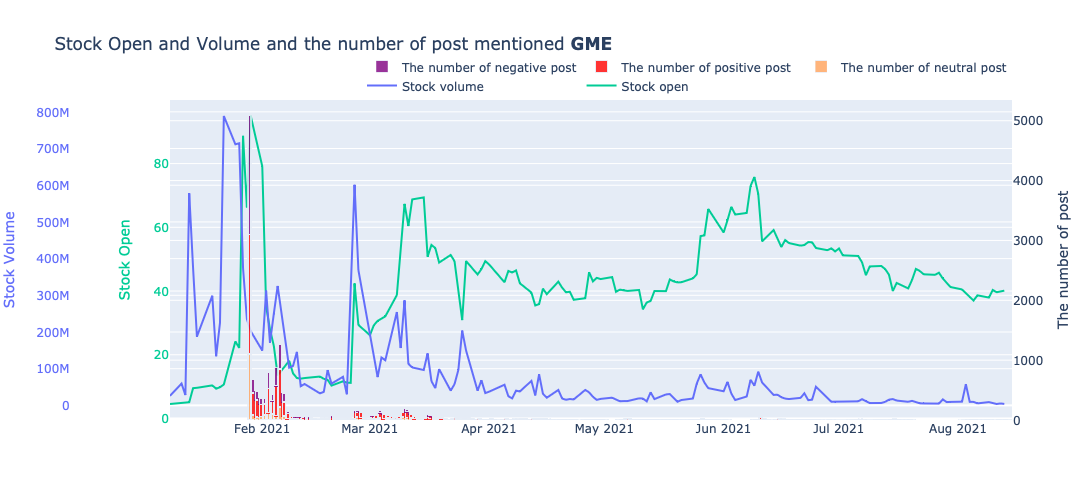

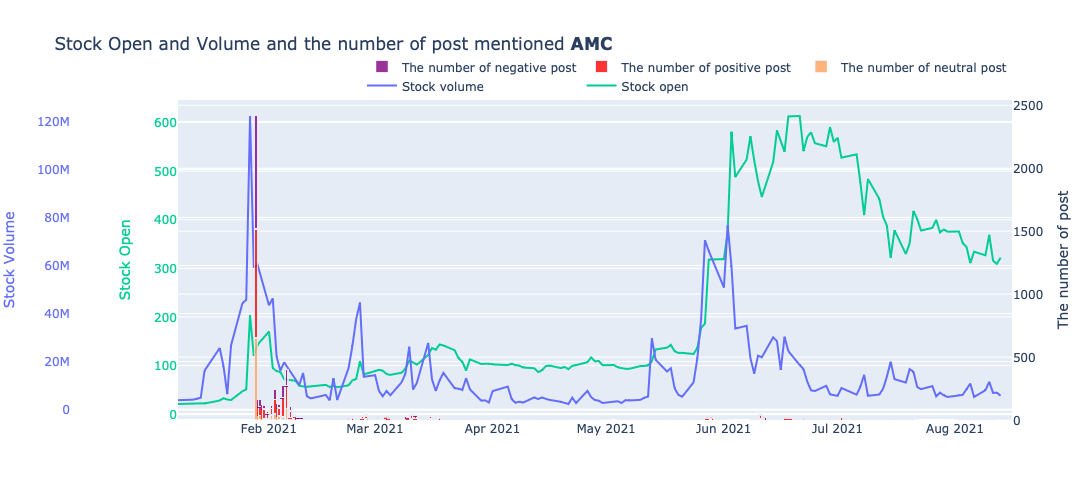

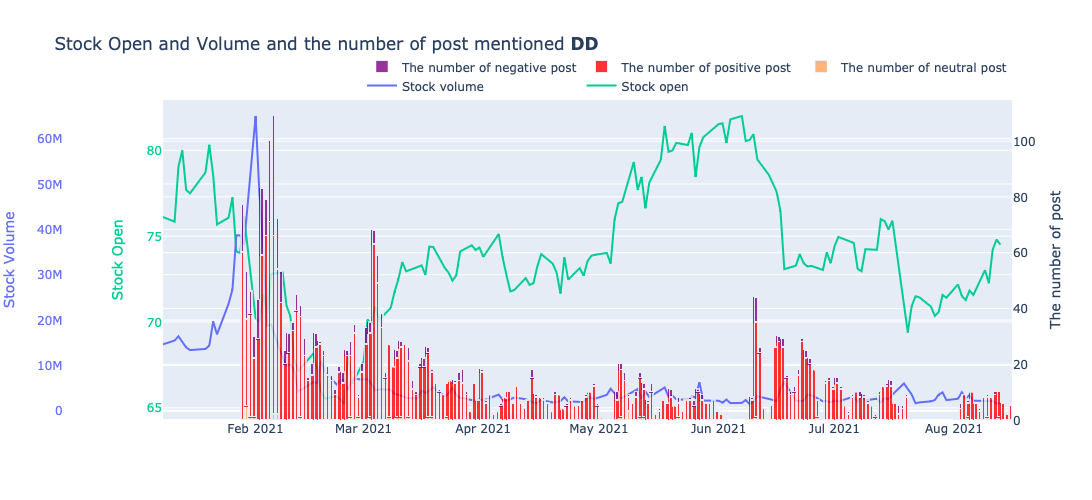

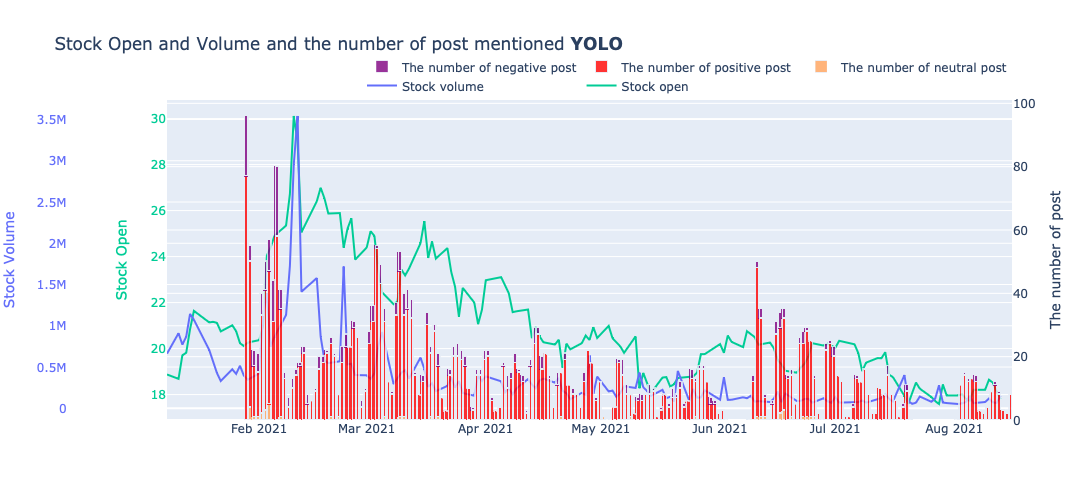

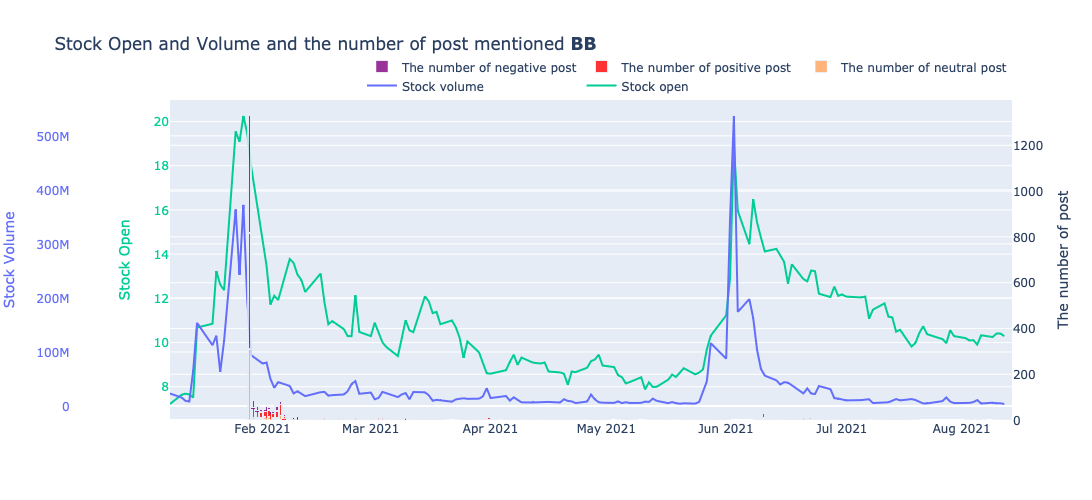

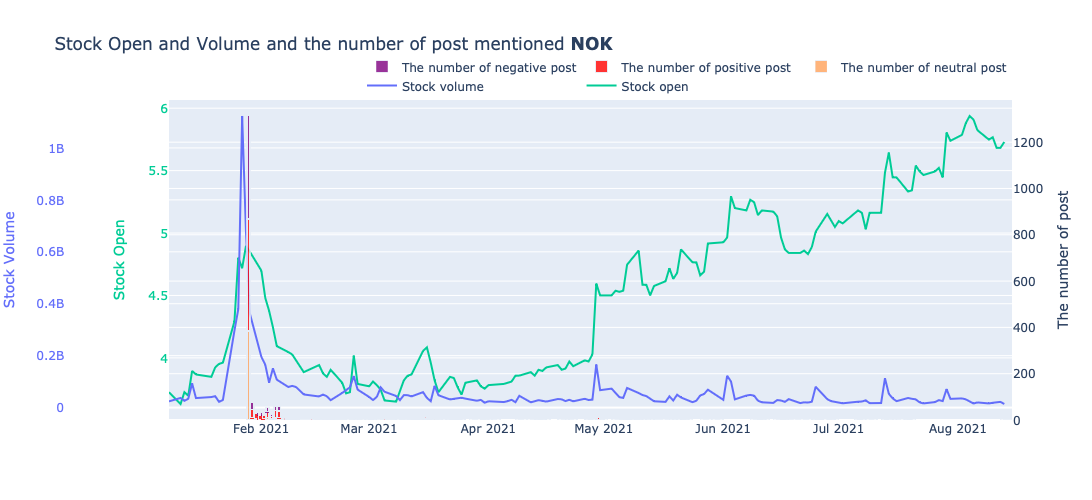

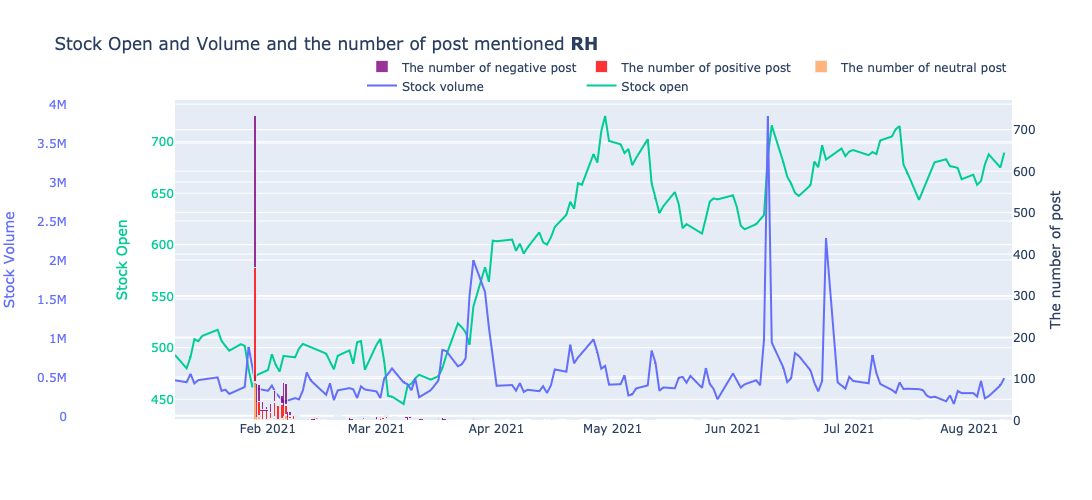

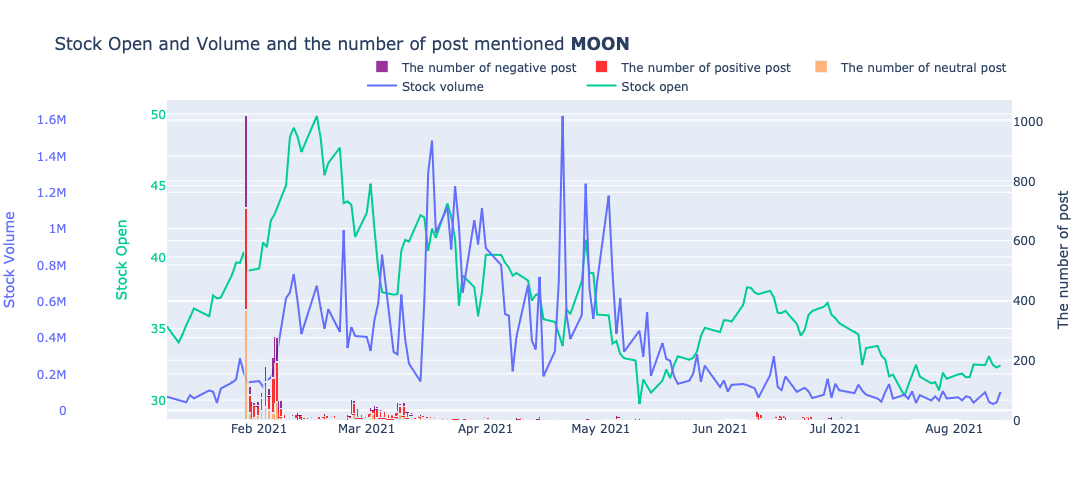

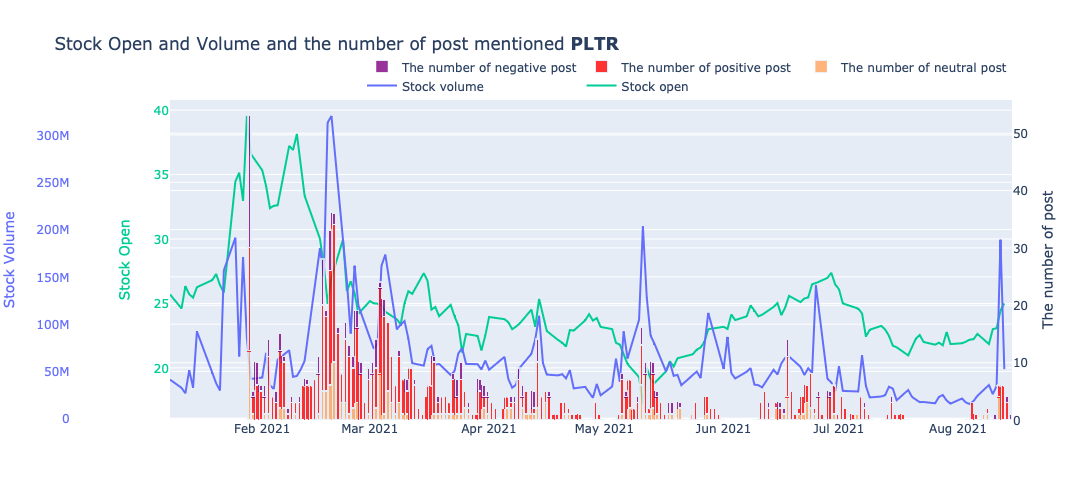

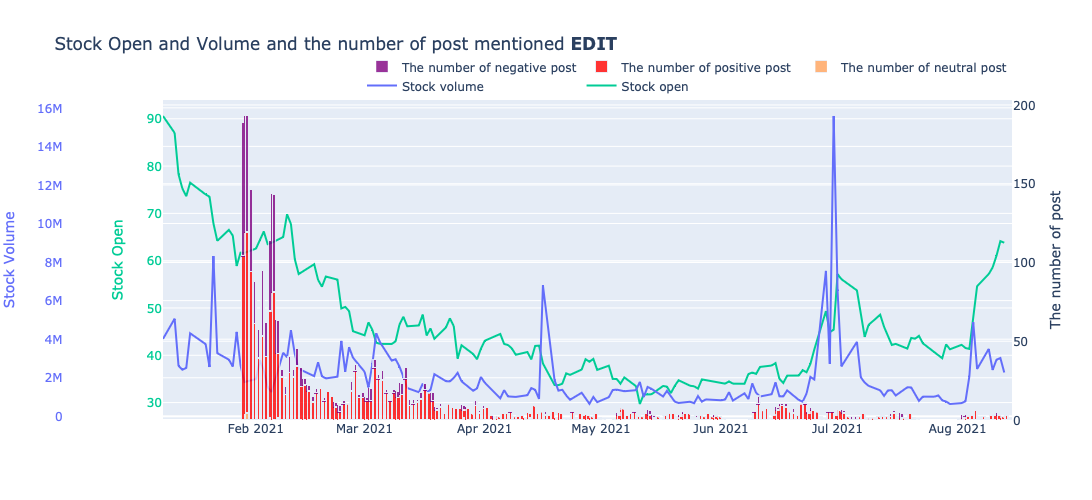

In [75]:
for ticker_symbol in ticker_symbol_top_n_kaggle:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

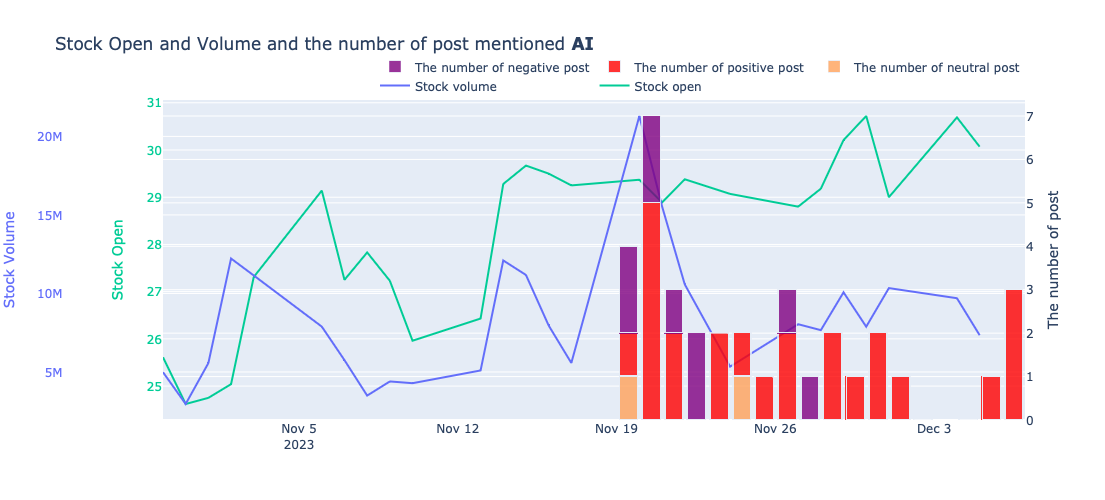

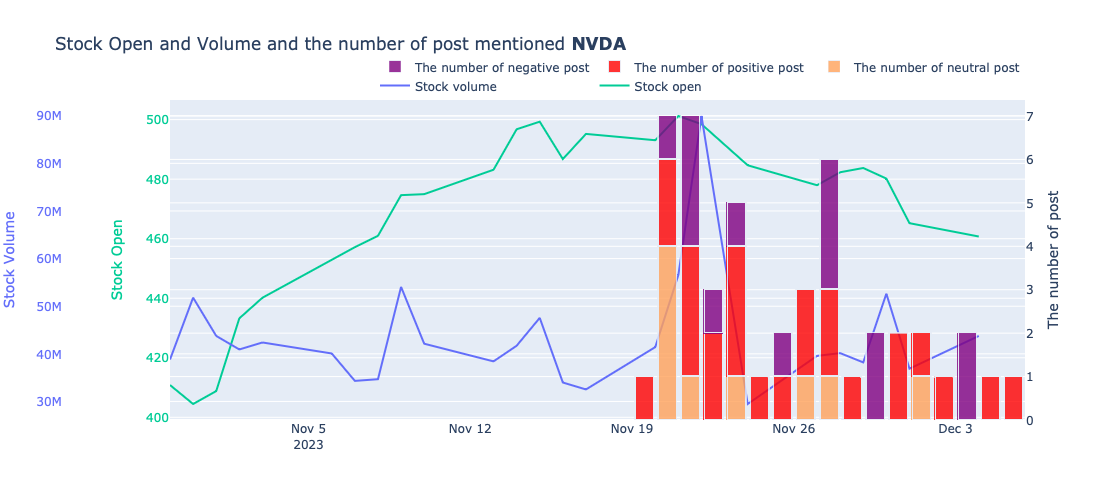

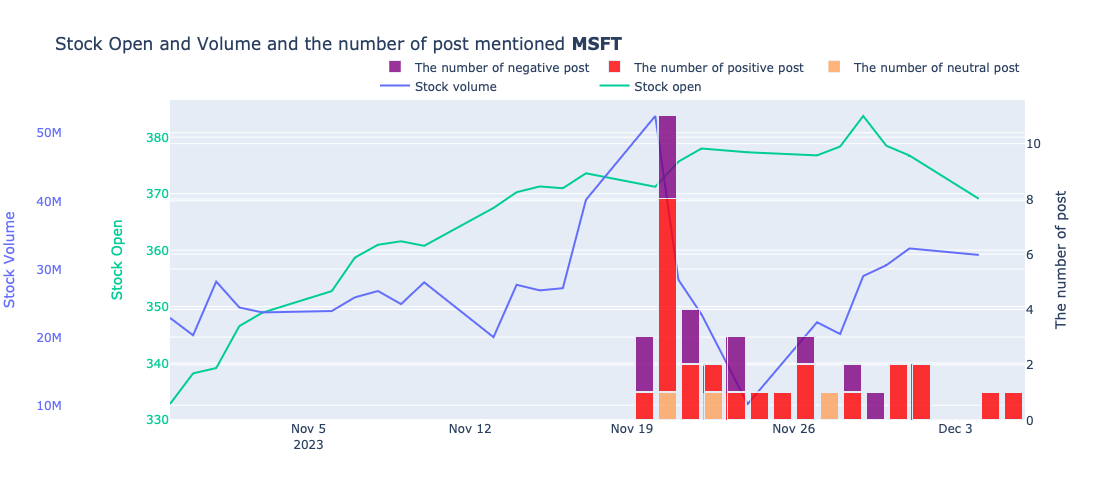

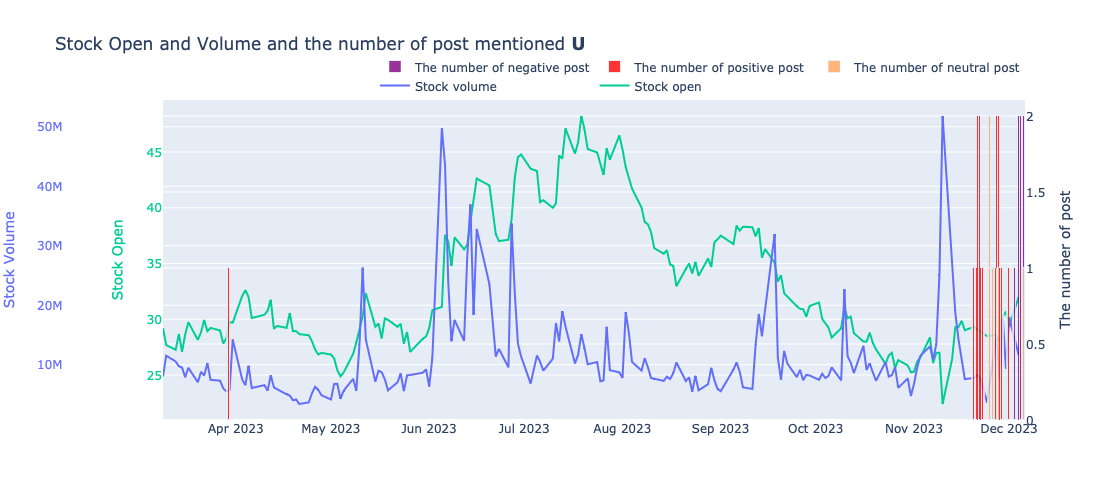

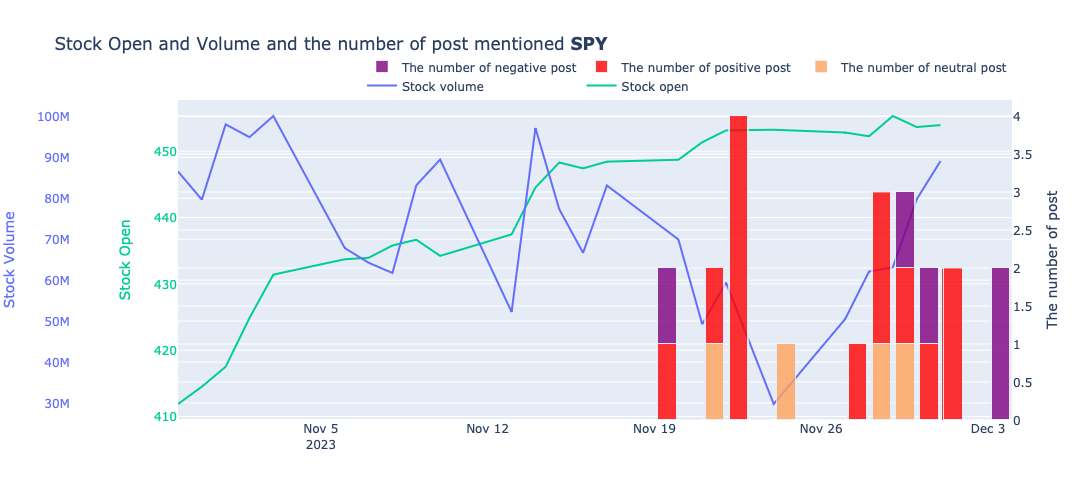

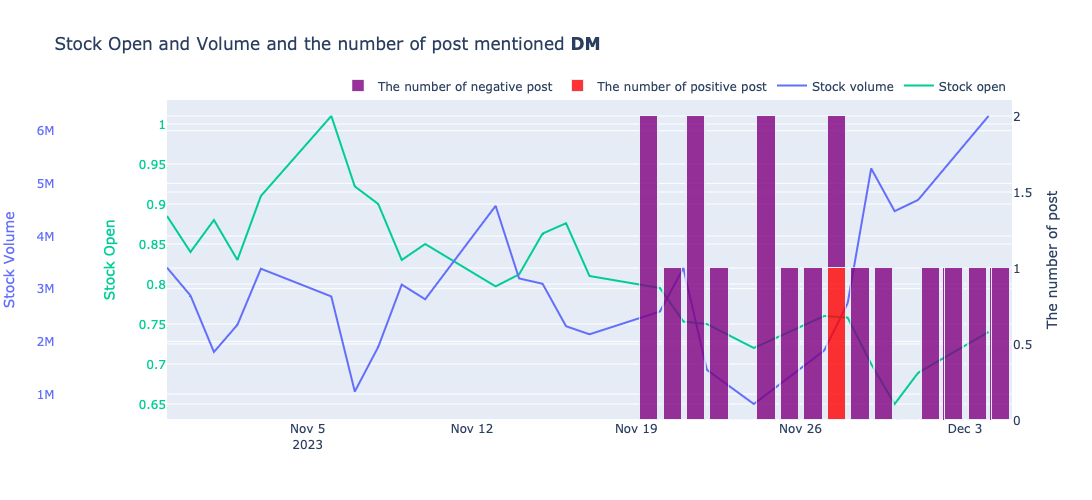

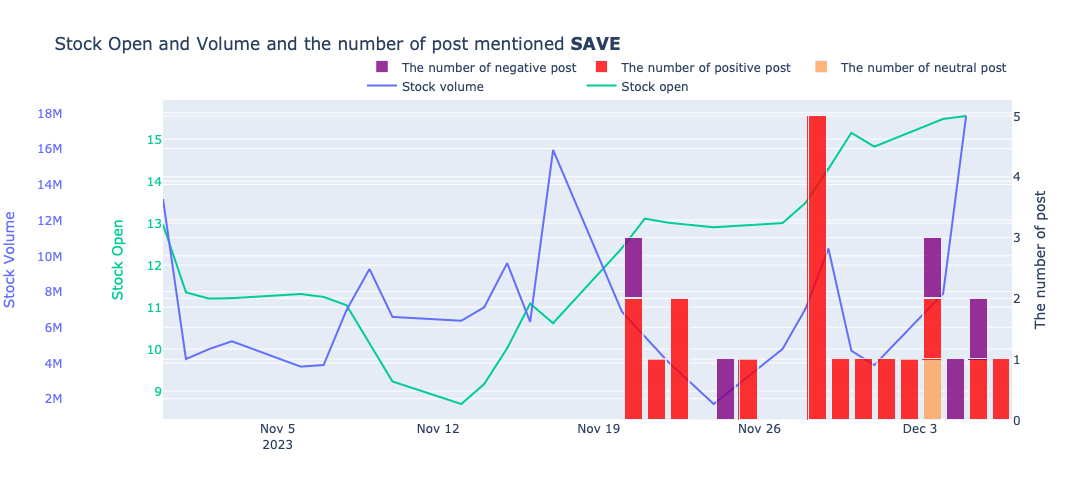

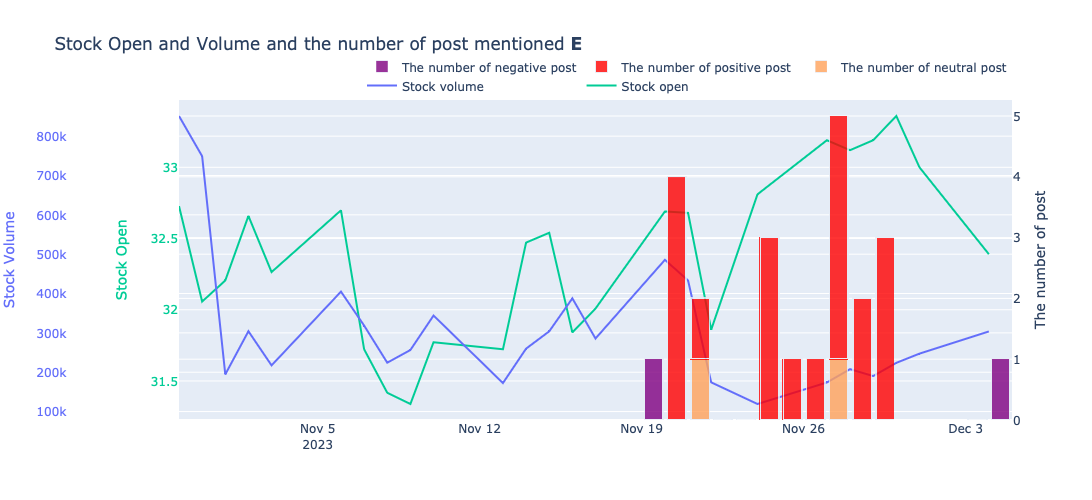

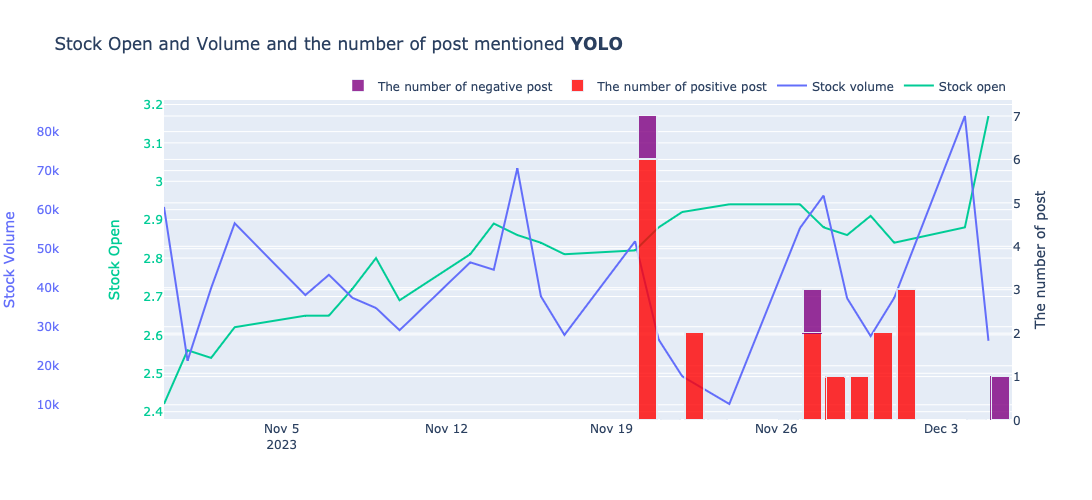

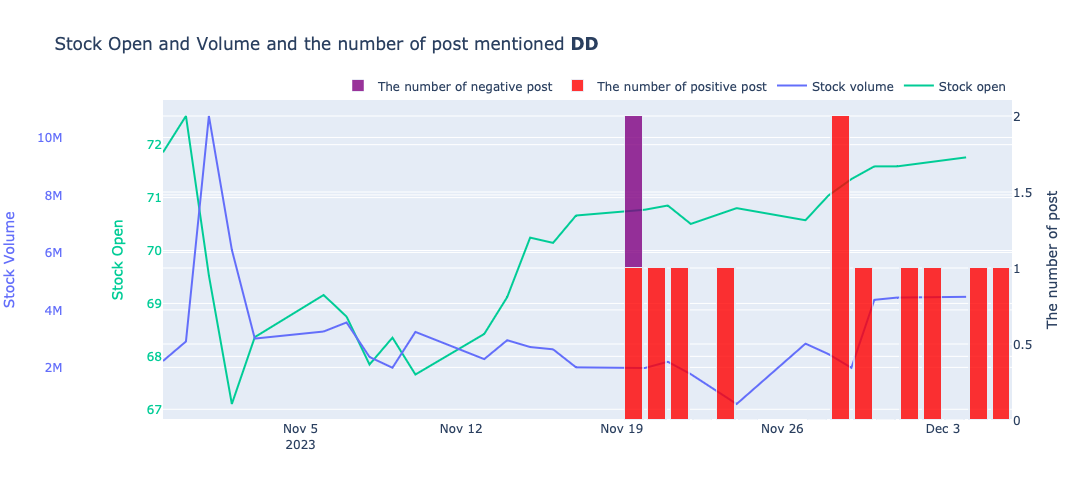

In [76]:
for ticker_symbol in ticker_symbol_top_n_2023:
    plot_stock_and_post_freq(df_2023, ticker_symbol)

## Method2: Use openai API to extract the ticker symbol in the context.

In [83]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

In [84]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

In [79]:
df_kaggle = pd.read_csv("./dataset/method2_analysis_result_kaggle.csv")

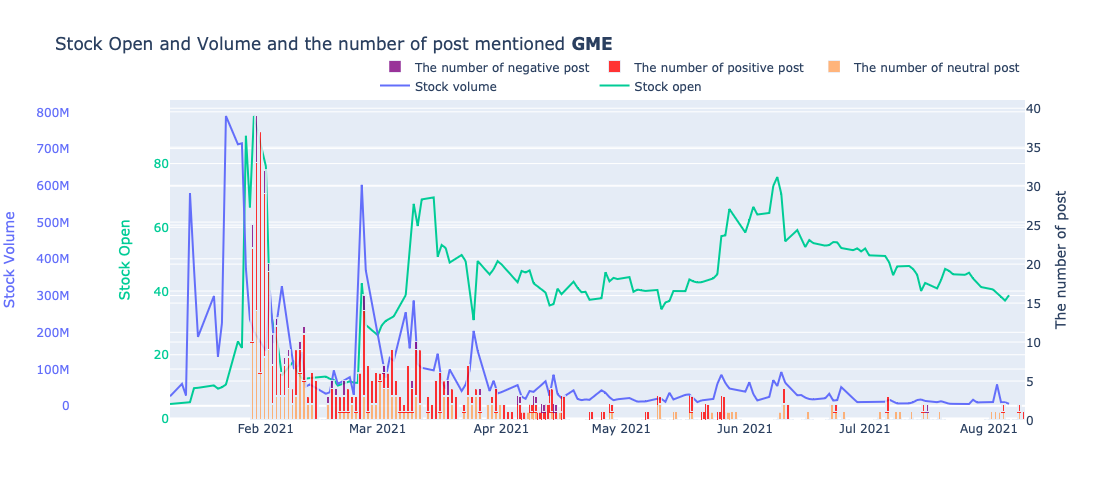

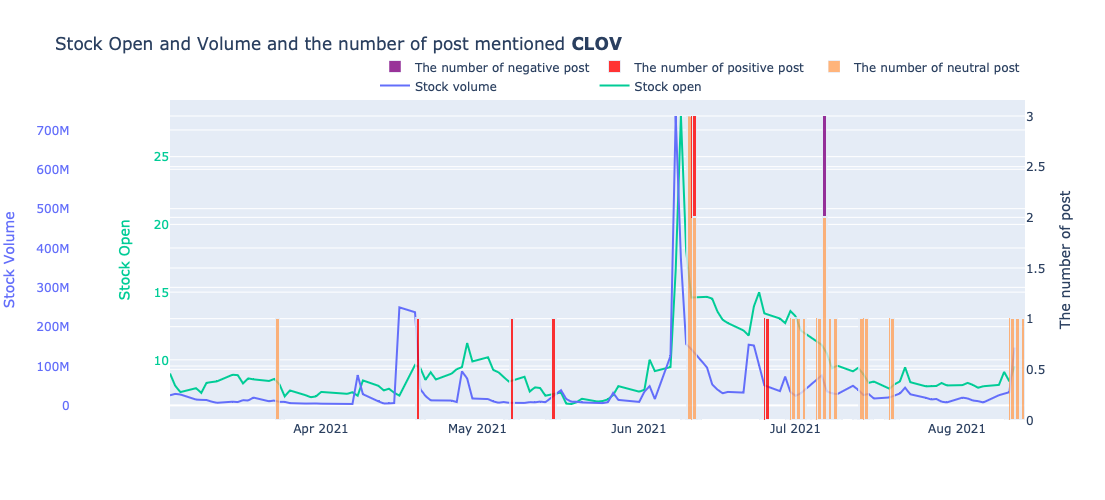

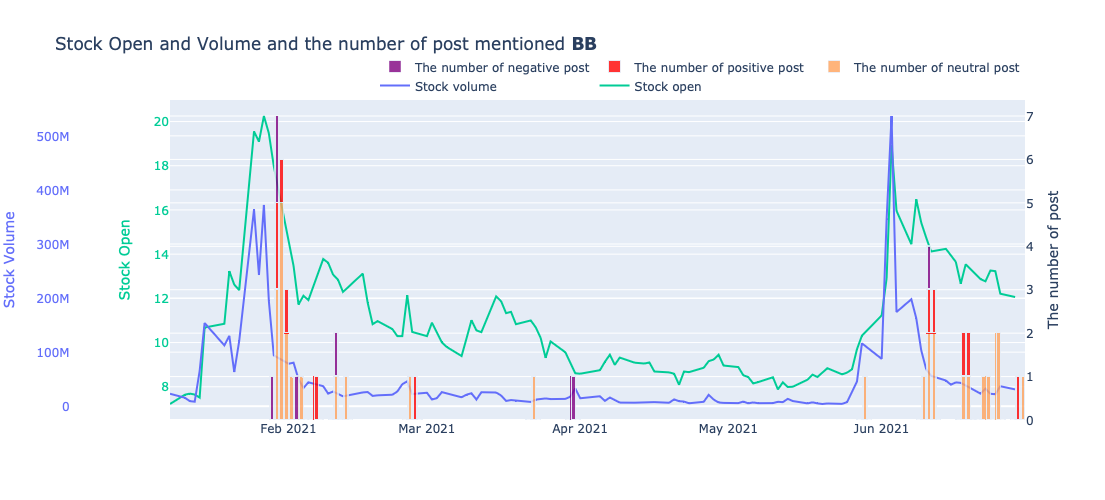

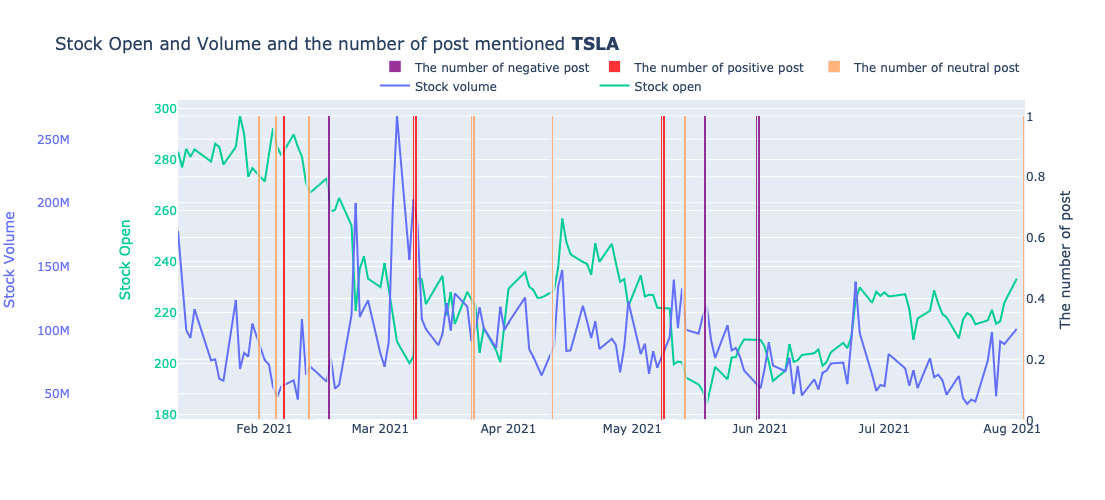

WSB: No price data found, symbol may be delisted (1d 2021-01-08 -> 2021-06-16)


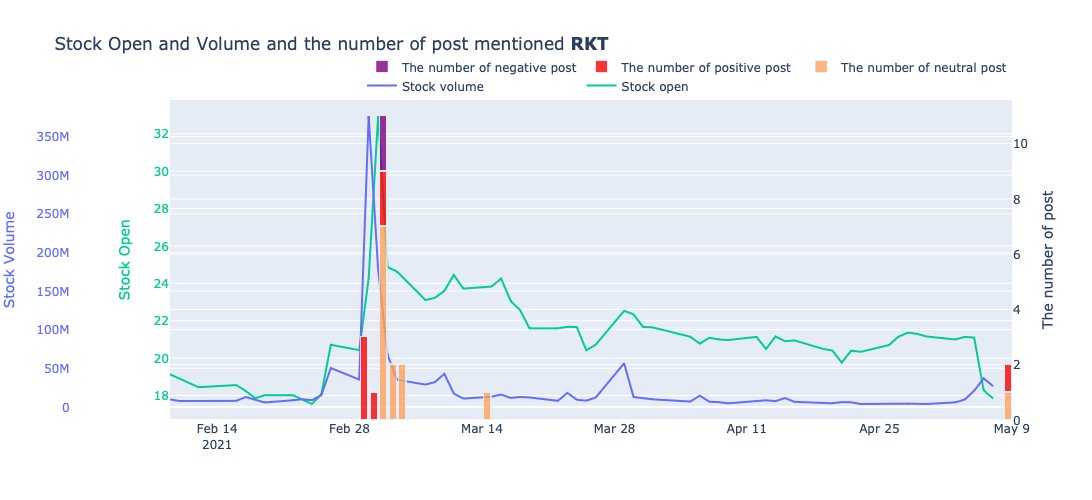

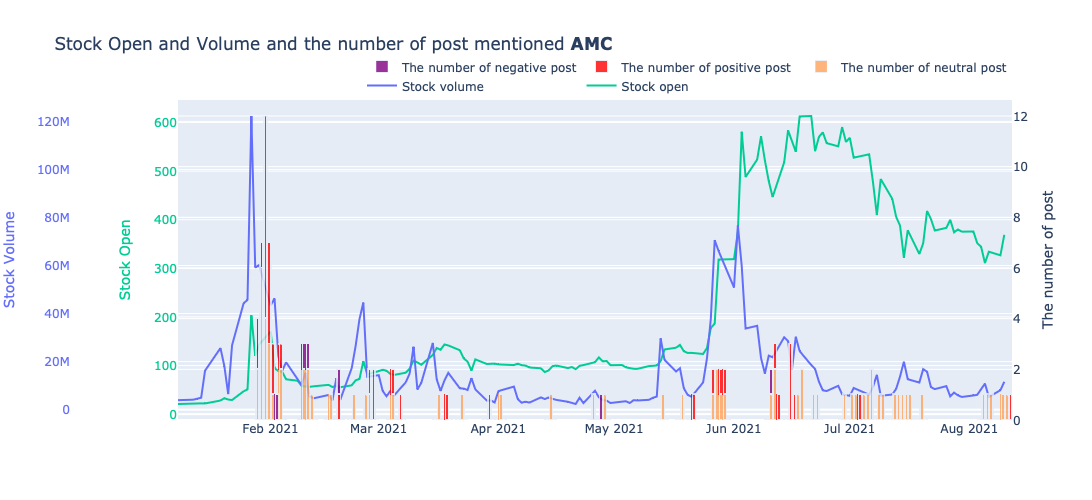

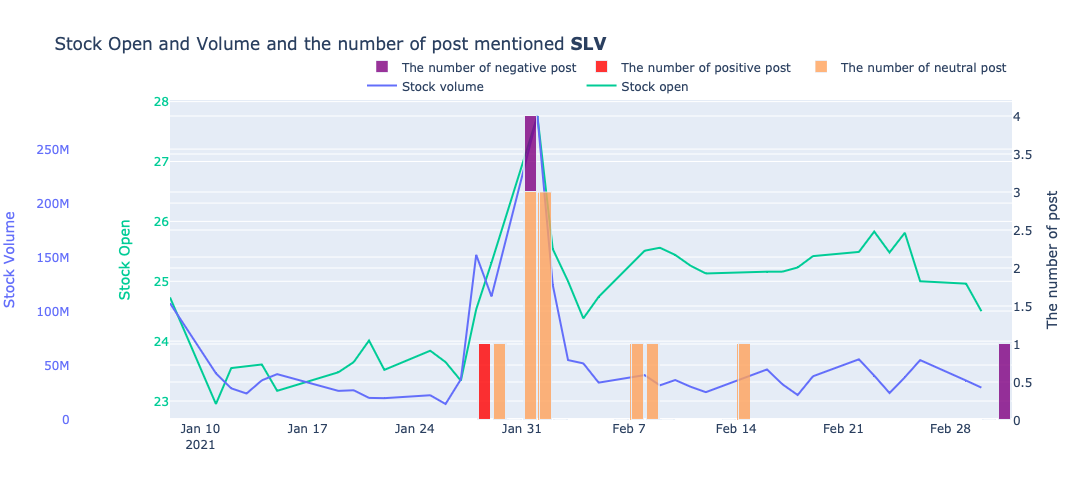

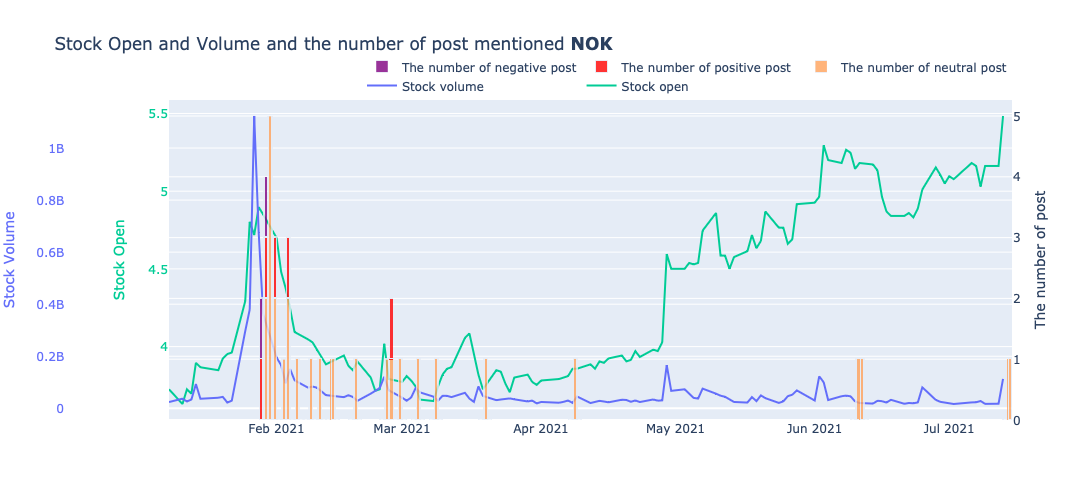

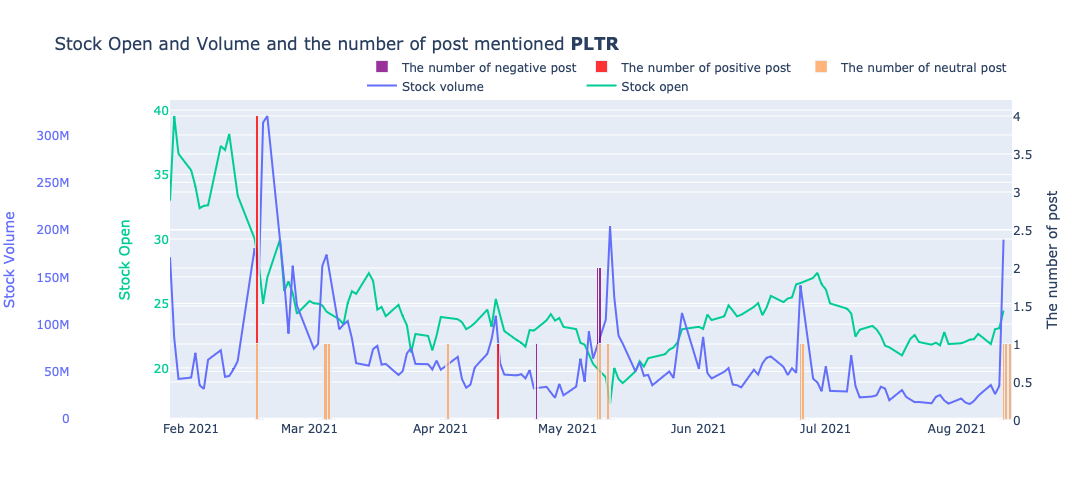

In [81]:
for ticker_symbol in df_kaggle.columns[-10:].values:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

# Correlation

In [88]:
df_kaggle = pd.read_csv("dataset/method1_analysis_result_kaggle.csv")

In [89]:
# stock_data should contain the data with a timestamp which is 1 interval later than end_time
def get_correlation(frequency_data, stock_data, start_time, end_time, mode="all", shift=timedelta(days=0), show_plot=False):
    if mode == "all":
        open_func = abs
    elif mode == "positive":
        open_func = operator.pos
    elif mode == "negative":
        open_func = operator.neg
    else:
        raise ValueError("Wrong mode")

    selected_frequency_data = frequency_data.loc[(frequency_data["timestamp"] >= start_time) & (frequency_data["timestamp"] < end_time)]
    selected_stock_data = stock_data.loc[(stock_data.index.tz_localize(None) >= start_time+shift) & (stock_data.index.tz_localize(None) < end_time+shift+(stock_data.index[1]-stock_data.index[0]))]
    if len(selected_frequency_data) == 0:
        raise ValueError(f"No freqency data in range of [{start_time+shift}, {end_time+shift})")
    if len(selected_stock_data) == 0:
        raise ValueError(f"No stock data in range of [{start_time+shift}, {end_time+shift})")
    elif len(selected_stock_data) == 1:
        raise ValueError(f"Stock data should contain at least 2 data in range of [{start_time+shift}, {end_time+shift})")

    # due to stock_data has no data during weekend, get a new frequency data
    stock_time = [time.date() for time in selected_stock_data.index[:-1]]
    new_freq = []
    cumulative_freq = 0
    i = 0
    for time in stock_time:
        if i >= len(selected_frequency_data["timestamp"]) or selected_frequency_data["timestamp"].iloc[i].date() > time:
            new_freq.append(0)
        else:
            cumulative_freq += selected_frequency_data["frequency"].iloc[i]
            i += 1
            while i < len(selected_frequency_data["timestamp"]) and selected_frequency_data["timestamp"].iloc[i].date() <= time:
                cumulative_freq += selected_frequency_data["frequency"].iloc[i]
                i += 1
            new_freq.append(cumulative_freq)
            cumulative_freq = 0

    # get difference between the next day open and today open
    new_open = []
    for i in range(0, len(selected_stock_data["Open"])-1):
        new_open.append(open_func(selected_stock_data["Open"].iloc[i+1] - selected_stock_data["Open"].iloc[i]))

    new_volume = []
    for i in range(0, len(selected_stock_data["Volume"])-1):
        new_volume.append(abs(selected_stock_data["Volume"].iloc[i+1] - selected_stock_data["Volume"].iloc[i]))

    if show_plot:
        # visualise relationship
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=new_freq,
            y=new_open,
            mode="markers"
        ))
        fig.update_layout(
            title_text="Correlation between Post Frequency and Open Price Difference",
            xaxis_title="number of posts",
            yaxis_title="open price differnce"
        )
        fig.show()
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=new_freq,
            y=new_volume,
            mode="markers"
        ))
        fig.update_layout(
            title_text="Correlation between Post Frequency and Volume Difference",
            xaxis_title="number of posts",
            yaxis_title="volume differnce"
        )
        fig.show()
    
    # calculate correlation
    open_correlation = scipy.stats.spearmanr(new_freq, new_open)
    volume_correlation = scipy.stats.spearmanr(new_freq, new_volume)
    

    freq_start_time = selected_frequency_data["timestamp"].iloc[0].to_pydatetime()
    freq_end_time = selected_frequency_data["timestamp"].iloc[-1].to_pydatetime()
    stock_start_time = selected_stock_data.index[0].tz_localize(None).to_pydatetime()
    
    stock_end_time = selected_stock_data.index[-2].tz_localize(None).to_pydatetime()

    return {
        "post_freq_start_time": freq_start_time,
        "post_freq_end_time": freq_end_time,
        "stock_start_time": stock_start_time,
        "stock_end_time": stock_end_time,
        "stock_open_price_correlation": open_correlation,
        "stock_volume_correlation": volume_correlation
    }

In [93]:
def format_correlation_result(df, target_ticker_symbol, start_timeshift = 0, end_timeshift = 5):
    # Prepare dataset
    df = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_all = get_post_freq(df["timestamp"], interval)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=30)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    # reserve for timeshift
    end_date = (datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=30)).strftime("%Y-%m-%d")
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")

    # dataframe output
    sentiment_mode_list = ["all", "positive", "negative"]
    index = pd.MultiIndex.from_tuples([(i, j) for i in sentiment_mode_list for j in ["Open", "Volume"]])
    df_result = pd.DataFrame(index = index).transpose().astype("object")
    df_result.index.rename("Timeshift", inplace = True)
    for df_freq, sentiment_mode in zip([df_freq_all, df_freq_positive, df_freq_negative], sentiment_mode_list):
        post_freq_threshold = df_freq["frequency"].median()
        timestamp = df_freq[df_freq["frequency"] > post_freq_threshold]["timestamp"]
        start_time, end_time = timestamp.iloc[0], timestamp.iloc[-1]
        for timeshift in range(start_timeshift, end_timeshift + 1):
            # df
            result = get_correlation(df_freq, df_stock, start_time, end_time, sentiment_mode, timedelta(days=timeshift))
            # display(result)
            df_result.loc[timeshift, sentiment_mode] = [
                f"{round(result['stock_open_price_correlation'][0], 4)} ({round(result['stock_open_price_correlation'][1], 4)})", 
                f"{round(result['stock_volume_correlation'][0], 4)} ({round(result['stock_volume_correlation'][1], 4)})"
            ]
            # df_result.loc[current_len, timeshift] = [result['stock_open_price_correlation'][0], result['stock_volume_correlation'][0]]

    return df_result

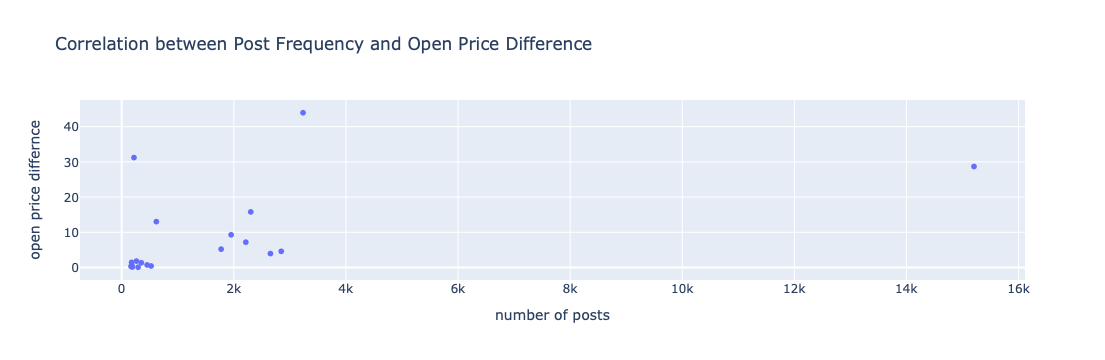

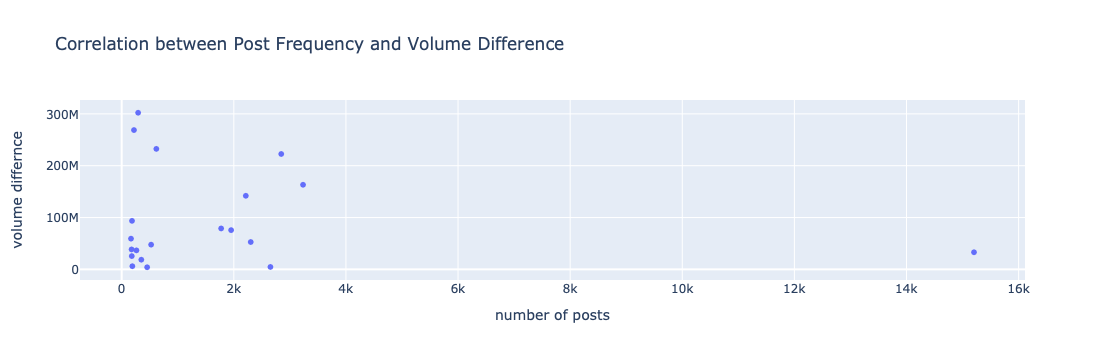

In [113]:
# Example
start_time = datetime.strptime(df_kaggle["timestamp"][0].split(" ")[0], "%Y-%m-%d")
end_time = start_time + timedelta(days=30)
df_freq = get_post_freq(df_kaggle["timestamp"], timedelta(days=1))
df_stock = yf.Ticker("GME").history(start = start_time, end = end_time, interval = "1d")
result = get_correlation(df_freq, df_stock, start_time, end_time, show_plot = True)

In [121]:
for ticker in df_kaggle.columns[-11:-1]:
    print(f"============={ticker}================")
    df_result = format_correlation_result(df_kaggle, ticker, start_timeshift = -2, end_timeshift = 2)
    display(df_result)

=============GME================


all                        positive                \
                      Open        Volume              Open        Volume   
Timeshift                                                                  
-2         0.3189 (0.0005)  0.5965 (0.0)  -0.0573 (0.5192)  0.6191 (0.0)   
-1         0.3378 (0.0002)  0.6345 (0.0)  -0.0737 (0.4062)  0.6347 (0.0)   
 0         0.3139 (0.0006)  0.6364 (0.0)  -0.0938 (0.2906)  0.6151 (0.0)   
 1         0.2969 (0.0013)   0.631 (0.0)  -0.0663 (0.4554)  0.6157 (0.0)   
 2         0.2969 (0.0013)   0.631 (0.0)  -0.0741 (0.4018)  0.6164 (0.0)   

                  negative                
                      Open        Volume  
Timeshift                                 
-2          0.057 (0.5433)  0.5837 (0.0)  
-1          0.0802 (0.392)  0.6044 (0.0)  
 0         0.1185 (0.2052)  0.6064 (0.0)  
 1          0.096 (0.3073)  0.6002 (0.0)  
 2          0.096 (0.3073)  0.6002 (0.0)

=============AMC================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2          0.0469 (0.595)  0.3399 (0.0001)    -0.002 (0.983)   
-1         0.0617 (0.4838)     0.3691 (0.0)  -0.0215 (0.8191)   
 0         0.0428 (0.6278)     0.3734 (0.0)  -0.0572 (0.5417)   
 1         0.0317 (0.7207)     0.3609 (0.0)  -0.0784 (0.4049)   
 2         0.0317 (0.7207)     0.3609 (0.0)  -0.0784 (0.4049)   

                                    negative                   
                    Volume              Open           Volume  
Timeshift                                                      
-2         0.2617 (0.0045)  -0.1092 (0.2143)  0.3407 (0.0001)  
-1         0.2882 (0.0017)   -0.0959 (0.276)     0.3622 (0.0)  
 0         0.2886 (0.0017)  -0.0701 (0.4261)     0.3702 (0.0)  
 1         0.2726 (0.0032)  -0.0523 (0.5548)     0.3568 (0.0)  
 2         0.2726 (0.0032)  -0.0523 (0.5548)     0.3568 (0.0)

=============DD================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1371 (0.1422)  0.1884 (0.0428)  -0.1006 (0.2527)   
-1          0.1204 (0.198)  0.1702 (0.0678)  -0.1058 (0.2289)   
 0          0.1104 (0.238)    0.1492 (0.11)  -0.1302 (0.1382)   
 1         0.0864 (0.3584)   0.1271 (0.176)  -0.1097 (0.2141)   
 2         0.0864 (0.3584)   0.1271 (0.176)  -0.1097 (0.2141)   

                                    negative                   
                    Volume              Open           Volume  
Timeshift                                                      
-2         0.1333 (0.1292)  -0.0255 (0.7747)  0.2084 (0.0182)  
-1         0.1159 (0.1873)  -0.0166 (0.8522)  0.2007 (0.0231)  
 0         0.0972 (0.2693)   -0.0021 (0.981)  0.1769 (0.0458)  
 1         0.0764 (0.3876)   -0.0301 (0.736)  0.1481 (0.0953)  
 2         0.0764 (0.3876)   -0.0251 (0.778)   0.1463 (0.098)

=============YOLO================


all                          positive                   \
                      Open           Volume             Open           Volume   
Timeshift                                                                       
-2         0.1861 (0.0464)  0.1938 (0.0379)   0.0645 (0.464)  0.2044 (0.0192)   
-1         0.1777 (0.0575)    0.21 (0.0243)  0.0624 (0.4792)    0.212 (0.015)   
 0          0.177 (0.0584)  0.2252 (0.0155)  0.0455 (0.6057)  0.2155 (0.0134)   
 1         0.2132 (0.0221)   0.237 (0.0108)  0.0401 (0.6503)  0.2161 (0.0135)   
 2         0.2132 (0.0221)   0.237 (0.0108)  0.0401 (0.6503)  0.2161 (0.0135)   

                   negative                   
                       Open           Volume  
Timeshift                                     
-2         -0.0906 (0.3016)   0.297 (0.0005)  
-1         -0.0803 (0.3602)  0.2993 (0.0005)  
 0          -0.0746 (0.397)  0.3064 (0.0004)  
 1         -0.0701 (0.4282)   0.309 (0.0003)  
 2         -0.0695 (0.4304)  0.3184 (0.0002)

=============BB================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1778 (0.0669)  0.2586 (0.0072)  -0.1009 (0.3013)   
-1         0.1959 (0.0432)  0.2917 (0.0023)    -0.1196 (0.22)   
 0         0.1899 (0.0501)  0.2807 (0.0034)  -0.0961 (0.3248)   
 1         0.1676 (0.0859)  0.2685 (0.0054)    -0.07 (0.4756)   
 2         0.1676 (0.0859)  0.2685 (0.0054)    -0.07 (0.4756)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.1985 (0.0404)  0.1418 (0.1573)  0.1597 (0.1106)  
-1          0.2264 (0.019)  0.1387 (0.1665)  0.1863 (0.0622)  
 0         0.2143 (0.0267)  0.1126 (0.2621)  0.1706 (0.0881)  
 1          0.2008 (0.039)  0.0701 (0.4858)  0.1402 (0.1619)  
 2          0.2008 (0.039)  0.0701 (0.4858)  0.1402 (0.1619)

=============NOK================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.2009 (0.0291)  0.2619 (0.0042)   -0.3001 (0.001)   
-1         0.2168 (0.0184)  0.2854 (0.0017)  -0.2761 (0.0025)   
 0         0.2219 (0.0158)  0.2651 (0.0037)  -0.2676 (0.0034)   
 1          0.1875 (0.042)  0.2552 (0.0053)  -0.2582 (0.0048)   
 2          0.1858 (0.043)   0.252 (0.0057)  -0.2498 (0.0062)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.2653 (0.0037)  0.3532 (0.0474)  0.3269 (0.0678)  
-1         0.2829 (0.0019)  0.3147 (0.0794)  0.4161 (0.0178)  
 0         0.2682 (0.0033)  0.2651 (0.1425)  0.3566 (0.0451)  
 1         0.2561 (0.0051)  0.1464 (0.4241)  0.2218 (0.2225)  
 2         0.2541 (0.0053)  0.1153 (0.5229)  0.1779 (0.3218)

=============RH================


all                           positive  \
                       Open           Volume              Open   
Timeshift                                                        
-2          -0.012 (0.8917)  0.0165 (0.8516)   -0.074 (0.6252)   
-1          -0.012 (0.8917)    0.018 (0.838)  -0.0944 (0.5326)   
 0         -0.0215 (0.8072)  0.0088 (0.9202)  -0.1479 (0.3268)   
 1          -0.014 (0.8746)  0.0268 (0.7621)  -0.1385 (0.3587)   
 2          -0.014 (0.8746)  0.0268 (0.7621)  -0.1526 (0.3057)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.3857 (0.0081)  -0.3923 (0.0218)  -0.4154 (0.0146)  
-1         -0.3615 (0.0136)  -0.3063 (0.0781)  -0.4269 (0.0118)  
 0          -0.425 (0.0032)   -0.212 (0.2288)  -0.4479 (0.0079)  
 1          -0.3991 (0.006)  -0.1992 (0.2663)  -0.4153 (0.0163)  
 2          -0.348 (0.0165)  -0.1992 (0.2663)  -0.4153 (0.0163)

=============MOON================


all                            positive  \
                      Open            Volume              Open   
Timeshift                                                        
-2         0.1876 (0.0428)   0.0016 (0.9859)  -0.0141 (0.8851)   
-1         0.1966 (0.0337)  -0.0009 (0.9927)   -0.001 (0.9919)   
 0         0.1871 (0.0443)    0.007 (0.9409)    0.019 (0.8463)   
 1         0.2087 (0.0252)    0.031 (0.7421)   0.0132 (0.8934)   
 2         0.1976 (0.0335)   0.0485 (0.6053)   0.0132 (0.8934)   

                                     negative                   
                     Volume              Open           Volume  
Timeshift                                                       
-2          -0.0933 (0.337)   0.0159 (0.8576)  0.0548 (0.5361)  
-1         -0.0954 (0.3258)   0.0059 (0.9473)  0.0615 (0.4873)  
 0          -0.086 (0.3785)  -0.0117 (0.8951)  0.0806 (0.3618)  
 1         -0.0628 (0.5223)   0.0029 (0.9736)   0.112 (0.2045)  
 2         -0.0628 (0.5223)   0.0029 (0.9736)   0.112 (0.2045)

=============PLTR================


all                           positive                  \
                   Open           Volume              Open          Volume   
Timeshift                                                                    
-2         0.3876 (0.0)     0.3639 (0.0)  -0.1867 (0.0295)    0.3689 (0.0)   
-1         0.4119 (0.0)     0.3801 (0.0)  -0.1728 (0.0442)    0.3809 (0.0)   
 0            0.4 (0.0)  0.3349 (0.0001)   -0.1755 (0.041)  0.329 (0.0001)   
 1         0.3918 (0.0)     0.3599 (0.0)  -0.1614 (0.0614)    0.3522 (0.0)   
 2         0.3918 (0.0)     0.3599 (0.0)  -0.1614 (0.0614)    0.3522 (0.0)   

                  negative                   
                      Open           Volume  
Timeshift                                    
-2          0.159 (0.1197)   0.199 (0.0507)  
-1         0.1384 (0.1764)   0.2167 (0.033)  
 0         0.1367 (0.1817)  0.1813 (0.0755)  
 1         0.1141 (0.2682)  0.2152 (0.0352)  
 2         0.1141 (0.2682)  0.2152 (0.0352)

=============EDIT================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.2084 (0.0169)  0.2904 (0.0008)  -0.0431 (0.6246)   
-1         0.2107 (0.0157)  0.2982 (0.0005)  -0.0355 (0.6876)   
 0         0.2113 (0.0154)  0.2637 (0.0023)  -0.0551 (0.5316)   
 1         0.2204 (0.0117)  0.2794 (0.0013)  -0.0657 (0.4575)   
 2         0.2204 (0.0117)  0.2794 (0.0013)  -0.0657 (0.4575)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2          0.2848 (0.001)  0.0662 (0.4575)    0.29 (0.0009)  
-1         0.2949 (0.0006)  0.0566 (0.5261)  0.3168 (0.0003)  
 0         0.2613 (0.0026)   0.0544 (0.542)  0.3108 (0.0004)  
 1          0.277 (0.0014)  0.0645 (0.4692)  0.3102 (0.0004)  
 2          0.277 (0.0014)  0.0785 (0.3764)  0.2905 (0.0008)

# Appendix

This appendix provide some trivial code that we already run it beforehand.

plot in three different figure

In [57]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    # df_neutral = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return

    fig_list = []
    for i in range(3):
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Open"],
                name = f"Stock open",
                marker=dict(color="#00CC96")
            )
        )
        
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Volume"],
                name = f"Stock volume",
                yaxis="y2",
                marker=dict(color="#636EFA")
            )
        )
        fig_list.append(fig)

    # color = ["#FFA15A", "red", "purple"]
    color = ["grey", "orange", "purple"]
    fig_list[0].add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color=color[0])
    ))
    fig_list[1].add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color=color[1])
    ))
    fig_list[2].add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.5,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color=color[2])
    ))

    # print(pd.Series(df_stock_date_list))
    # print(df_freq_positive["timestamp"])
    
    for i, fig in enumerate(fig_list):
        # Create axis objects
        fig.update_layout(
            yaxis=dict(
                title=f"Stock Open",
                titlefont=dict(
                    color="#00CC96"
                ),
                tickfont=dict(
                    color="#00CC96"
                )
            ),
            yaxis2=dict(
                title=f"Stock Volume",
                titlefont=dict(
                    color="#636EFA"
                ),
                tickfont=dict(
                    color="#636EFA"
                ),
                anchor="free",
                overlaying="y",
                side="left",
                autoshift=True,
                shift=-50,
            ),
            yaxis3=dict(
                title="The number of post",
                titlefont=dict(
                    color=color[i]
                ),
                tickfont=dict(
                    color=color[i]
                ),
                anchor="x",
                overlaying="y",
                side="right",
            ),
        )
        # Update layout properties
        fig.update_layout(
            title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
            width=1000,
            height=500,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
    
        fig.show()
    # fig.write_html("test.html")